# Аналитика в Яндекс.Афише

Перед нами стоит задача проанализировать работу Яндекс.Афиши и ответить на следующие вопросы:
  #### Продукт
  
Сколько людей пользуются в день, неделю, месяц?
Сколько сессий в день?
Сколько длится одна сессия?
Как часто люди возвращаются?
   #### Продажи
   
Когда люди начинают покупать?
Сколько раз покупают за период?
Какой средний чек?
Сколько денег приносят? (LTV)
   #### Маркетинг
   
Сколько денег потратили? Всего / на каждый источник / по времени
Сколько стоило привлечение одного покупателя из каждого источника?
На сколько окупились расходы? (ROI)

Для отета на данные вопросы у нас есть следующие данные:

Описание данных

Таблица visits (лог сервера с информацией о посещениях сайта):

Uid — уникальный идентификатор пользователя

Device — категория устройства пользователя

Start Ts — дата и время начала сессии

End Ts — дата и время окончания сессии

Source Id — идентификатор рекламного источника, из которого пришел пользователь


Таблица orders (информация о заказах):

Uid — уникальный id пользователя, который сделал заказ

Buy Ts — дата и время заказа

Revenue — выручка Яндекс.Афиши с этого заказа


Таблица costs (информация о затратах на маркетинг):

source_id — идентификатор рекламного источника

dt — дата

costs — затраты на этот рекламный источник в этот день

#### Оглавление
* [Импорт библиотек](#first-bullet)
* [1. Открытие данных](#second-bullet)
* [2. Предобработка данных](#2-bullet)
* [3. Исследовательский анализ данных](#3-bullet)    
* [ Общий вывод](#5-bullet)

#### Импорт библиотек <a class="anchor" id="first-bullet"></a>


In [60]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

#### 1. Открытие данных <a class="anchor" id="second-bullet"></a>

In [61]:
visits=pd.read_csv('/datasets/visits_log.csv')
display(visits.head())
visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [62]:
orders=pd.read_csv('/datasets/orders_log.csv')
display(orders.head())

orders.info()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [63]:
costs=pd.read_csv('/datasets/costs.csv')
display(costs.tail(15))
costs.info()

,source_id,dt,costs
2527,10,2018-05-17,13.66
2528,10,2018-05-18,15.51
2529,10,2018-05-19,18.33
2530,10,2018-05-20,6.46
2531,10,2018-05-21,13.76
2532,10,2018-05-22,21.70
2533,10,2018-05-23,7.42
2534,10,2018-05-24,10.79
2535,10,2018-05-25,22.21
2536,10,2018-05-26,7.89


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Данные нормальные, пропускоы не обнаружено. Необходимо перевести даты в формат datatime. Так будет легче вести всю дальнейшую аналитику.

#### 2. Предобработка данных <a class="anchor" id="2-bullet"></a>

In [64]:
visits['End Ts']=pd.to_datetime(visits['End Ts'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: datetime64[ns](1), int64(1), object(2), uint64(1)
memory usage: 13.7+ MB


In [65]:
visits['Start Ts']=pd.to_datetime(visits['Start Ts'])


In [66]:
orders['Buy Ts']=pd.to_datetime(orders['Buy Ts'])

In [67]:
costs['dt']=pd.to_datetime(costs['dt'])

In [68]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Перевели даты в фортат datetime во всех таблицах.

#### 3. Иследовательский анализ данных <a class="anchor" id="3-bullet"></a>

###### Продукт

In [69]:
visits['Start Ts_year']=visits['Start Ts'].dt.year
visits['Start Ts_month']=visits['Start Ts'].dt.month
visits['Start Ts_week']=visits['Start Ts'].dt.week
visits['Start Ts_date']=visits['Start Ts'].dt.date
visits['End Ts_date']=visits['End Ts'].dt.date
display(visits.head(2))

,Device,End Ts,Source Id,Start Ts,Uid,Start Ts_year,Start Ts_month,Start Ts_week,Start Ts_date,End Ts_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,2018-02-19


In [70]:
dau_total=visits.groupby('Start Ts_date').agg({'Uid':'nunique'}).mean()
print(int(dau_total))

907


Яндекс.афишу посещают в среднем 907 человек в день.

In [71]:
wau_total=visits.groupby(['Start Ts_year','Start Ts_week']).agg({'Uid':'nunique'}).mean()
print(int(wau_total))

5716


5716 пользователей в неделю

In [72]:
mau_total=visits.groupby(['Start Ts_year','Start Ts_month']).agg({'Uid':'nunique'}).mean()
print(int(mau_total))

23228


23228 пользователей в месяц.

In [73]:
visits['sessions']=(visits['End Ts']-visits['Start Ts']).dt.seconds 

In [74]:
visit_sessia=visits.groupby('Start Ts_date')['sessions'].count().reset_index()
display(visit_sessia.head())
print(visit_sessia['sessions'].mean())

,Start Ts_date,sessions
0,2017-06-01,664
1,2017-06-02,658
2,2017-06-03,477
3,2017-06-04,510
4,2017-06-05,893


987.3626373626373


В среднем яндекс.афиша имеет 987 сессий в день. Почти совпадает с количеством посетителей в день.

In [75]:
print(visits['sessions'].sum()/visits['sessions'].count())

643.506488592098


В среднем сессия длится 643 секунды или 11 минут. Изобразим на граффике.


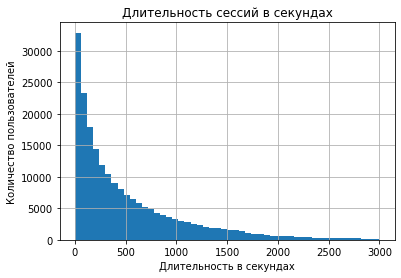

Диаграмма размаха  длительности сессии в секундах


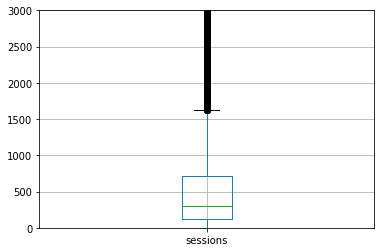

count    228169.000000
mean        527.334184
std         674.694861
min           0.000000
25%         120.000000
50%         300.000000
75%         720.000000
max       20940.000000
Name: sessions, dtype: float64


In [76]:
visit_sessia_seconds=visits.groupby('Uid').agg({'sessions':'mean'})
visit_sessia_seconds.hist(bins=50, range=(1,3000))
plt.title('Длительность сессий в секундах')
ax = plt.gca()
ax.set_xlabel('Длительность в секундах')
ax.set_ylabel('Количество пользователей')
plt.show()
print ('\033[1m' + 'Диаграмма размаха  длительности сессии в секундах' + '\033[0m')
visit_sessia_seconds.boxplot(column='sessions')
plt.ylim(0,3000)
plt.show()
print(visit_sessia_seconds['sessions'].describe())

Посмотрев на диаграмму, можно сделать вывод, что распределение не является нормальным . Есть большое количество выбросов.



In [77]:
print(visits['sessions'].median())

300.0



Медианное значение длительности сессии пользователей за период составила 300 секунд (или 5 минут)

In [78]:
visit_id=visits.groupby('Uid').agg({'Start Ts':'count'}).reset_index()
display(visit_id.head(2))

,Uid,Start Ts
0,11863502262781,1
1,49537067089222,1


Составили таблицу с количеством посещений по каждому пользователю.

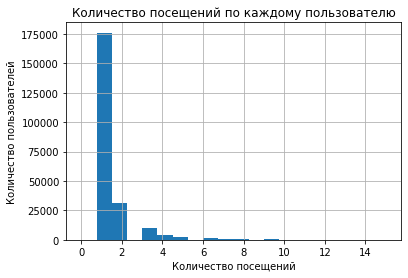

In [79]:
visit_id['Start Ts'].hist(bins=20, range=(0,15))
plt.title('Количество посещений по каждому пользователю')
ax = plt.gca()
ax.set_xlabel('Количество посещений')
ax.set_ylabel('Количество пользователей')
plt.show()

По данной таблице можно сделать вывод , что посетители в основном посещают яндекс афишу всего один раз. 
Редко кто возвращается чаще 2 раз.

In [80]:
Visit_min=visits.groupby('Uid')['Start Ts_date'].min()
orders_min=orders.groupby('Uid')['Buy Ts'].min()
Visit_min.name='first_Start Ts_date'
orders_min.name='first_Start Ts_date'
orders=orders.join(orders_min, on='Uid')
orders['first_Start_date']=orders['first_Start Ts_date']
orders['Buy_Ts_date']=orders['Buy Ts']
orders['first_Start Ts_date']=orders['first_Start Ts_date'].astype('datetime64[M]')
orders['Buy Ts']=orders['Buy Ts'].astype('datetime64[M]')
orders['life_time']=((orders['Buy Ts']-orders['first_Start Ts_date'])/np.timedelta64(1,'M')).round().astype('int')





In [81]:
orders_cohort=orders.groupby(['first_Start Ts_date','life_time']).agg({'Uid':'nunique'}).reset_index()
orders_cohort_0=orders_cohort[orders_cohort['life_time']==0][['first_Start Ts_date','Uid']].reset_index()
orders_cohort_0 = orders_cohort_0.rename(columns={'Uid':'cohort_uid'}) 
orders_cohort=orders_cohort.merge(orders_cohort_0, on='first_Start Ts_date')
orders_cohort['retention']=orders_cohort['Uid']/orders_cohort['cohort_uid']
orders_cohort_table=orders_cohort.pivot_table(index='first_Start Ts_date', columns='life_time', values='retention')

In [82]:

visits2=visits.merge(Visit_min, on='Uid')
visits2['first_Start Ts_date']=visits2['first_Start Ts_date'].astype('datetime64[M]')
visits2['Start Ts_date']=visits2['Start Ts_date'].astype('datetime64[M]')
visits2['life_time']=((visits2['Start Ts_date']-visits2['first_Start Ts_date'])/np.timedelta64(1,'M')).round().astype('int')




,Device,End Ts,Source Id,Start Ts,Uid,Start Ts_year,Start Ts_month,Start Ts_week,Start Ts_date,End Ts_date,sessions,first_Start Ts_date,life_time
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-01,2017-12-20,1080,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-01,2018-02-19,1680,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,2017-07-01,0,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-01,2018-05-20,1440,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-01,2018-03-09,1680,2018-03-01,0


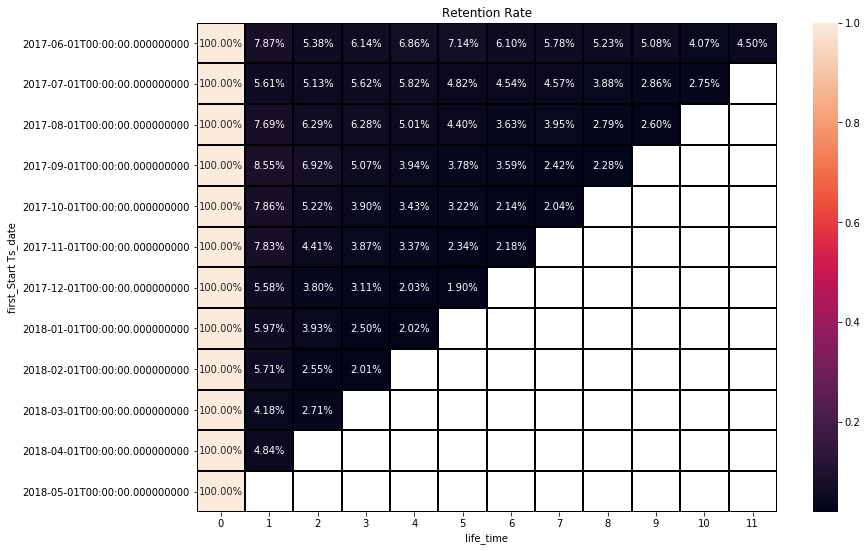

In [83]:
cohort_visits2=visits2.groupby(['first_Start Ts_date','life_time']).agg({'Uid':'nunique'}).reset_index()
cohort_0_visits2=cohort_visits2[cohort_visits2['life_time']==0][['first_Start Ts_date','Uid']].reset_index()
cohort_0_visits2 = cohort_0_visits2.rename(columns={'Uid':'cohort_uid'})

cohort_visits2=cohort_visits2.merge(cohort_0_visits2, on='first_Start Ts_date')
cohort_visits2['retention']=cohort_visits2['Uid']/cohort_visits2['cohort_uid']
cohort_visits2_table=cohort_visits2.pivot_table(index='first_Start Ts_date', columns='life_time', values='retention')

display(visits2.head())
plt.figure(figsize=(13,9))
plt.title('Retention Rate')
sns.heatmap(cohort_visits2_table, annot= True,fmt='.2%', linewidths=1, linecolor='black')



    Посчитала Retention Rate. Тогда вывод будет следующим:
    Яндекс афишу чаще всего пользователи заходят всего один раз. В среднем на следующий месяц после первого посещения остается  всего 7% пользователей. Отличилась сентябрьская когорта , где процент возвращенных пользователей превысил 8%
    

##### Продажи

In [84]:
Visit_min=visits.groupby('Uid')['Start Ts_date'].min().reset_index()
Visit_min.name='first_Start Ts_date'
display(Visit_min.head())

,Uid,Start Ts_date
0,11863502262781,2018-03-01
1,49537067089222,2018-02-06
2,297729379853735,2017-06-07
3,313578113262317,2017-09-18
4,325320750514679,2017-09-30


In [85]:
orders=orders.merge(Visit_min, on='Uid')

orders['first_Start Ts_date']=orders['Start Ts_date'].astype('datetime64[M]')
orders['Buy Ts']=orders['Buy Ts'].astype('datetime64[M]')
orders['life_time']=((orders['Buy Ts']-orders['first_Start Ts_date'])/np.timedelta64(1,'M')).round().astype('int')


Нашли первое посещение пользователя за период.

In [86]:
display(Visit_min.tail(2))
Visit_min=Visit_min.reset_index()
orders_Buy_min=orders.groupby('Uid')['Buy_Ts_date'].min().reset_index()
orders_Buy_min['Buy_Ts_date']=pd.to_datetime(orders_Buy_min['Buy_Ts_date']).dt.date
display(orders_Buy_min.tail(2))
orders_Visit_min=Visit_min.merge(orders_Buy_min, on='Uid')
orders_Visit_min['delta']=(orders_Visit_min['Buy_Ts_date']-orders_Visit_min['Start Ts_date'])/np.timedelta64(1,'D')
display(orders_Visit_min.tail(2))


,Uid,Start Ts_date
228167,18446621818809592527,2017-12-27
228168,18446676030785672386,2017-10-04


,Uid,Buy_Ts_date
36521,18446156210226471712,2018-02-18
36522,18446167067214817906,2017-10-17


,index,Uid,Start Ts_date,Buy_Ts_date,delta
36521,228161,18446156210226471712,2017-11-07,2018-02-18,103.0
36522,228162,18446167067214817906,2017-10-17,2017-10-17,0.0


Text(0, 0.5, 'Количество посетителей')

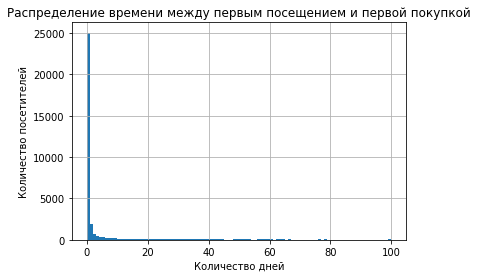

In [87]:
orders_Visit_min['delta'].hist(bins=100, range=(0,100))
plt.title('Распределение времени между первым посещением и первой покупкой')
ax = plt.gca()
ax.set_xlabel('Количество дней')
ax.set_ylabel('Количество посетителей')


График  показал , что в большинстве случаев клиенты покупают сразу после первого посещения сайта . Лишь немногие совершают покупки во время последующих визитов.

Посмотрим продажи в разрезе периодов

Text(0.5, 1.0, 'Количество продаж по месяцам')

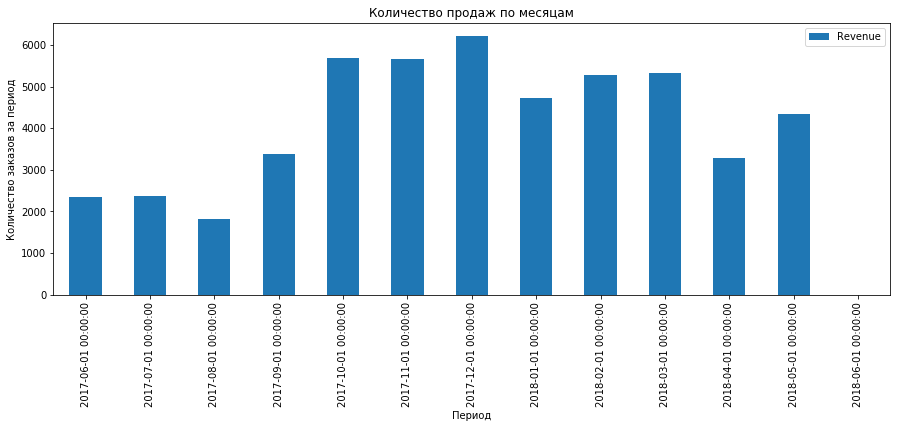

In [88]:
table_date_count=orders.pivot_table(index='Buy Ts', values='Revenue', aggfunc='count').reset_index()
table_date_count.plot(x='Buy Ts',legend=True,figsize=(15,5), kind='bar')
ax = plt.gca() 
ax.set_xlabel('Период')
ax.set_ylabel('Количество заказов за период')
plt.title('Количество продаж по месяцам')


Text(0.5, 1.0, 'Сумма продаж по месяцам')

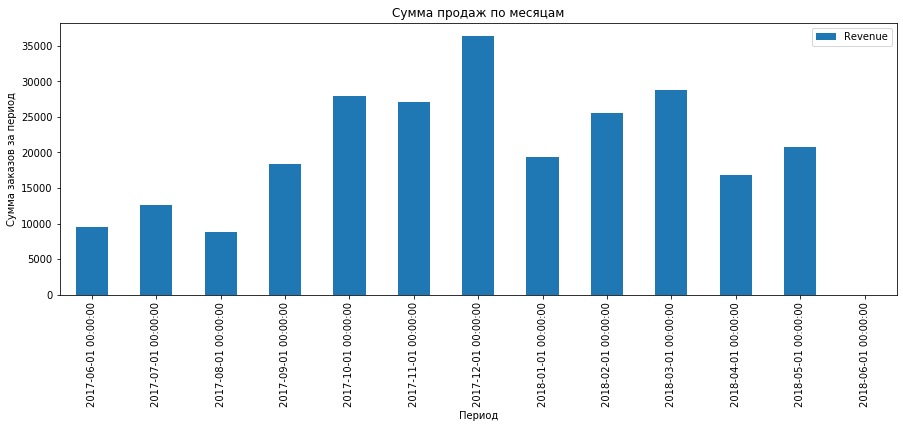

In [89]:
table_date_count=orders.pivot_table(index='Buy Ts', values='Revenue', aggfunc='sum').reset_index()
table_date_count.plot(x='Buy Ts',legend=True,figsize=(15,5), kind='bar')
ax = plt.gca() 
ax.set_xlabel('Период')
ax.set_ylabel('Сумма заказов за период')
plt.title('Сумма продаж по месяцам')

Сформировав графики продаж в по количеству и суммам заказов, можно сделать вывод , что продажи яндекс.афиши неравномерные. К концу года количество заказов , соответственно и выручка , увеличилась в несколько раз по сравнению с предыдущими периодами. Это может быть свзяно с обычной сезонностью в яндекс. афише , а может быть совпадением . В этот период могло проходить несколько удачных мероприятий, которые смогли собрать большое количество заказов пользователей.

In [90]:
orders_uid=orders.groupby('Buy Ts').agg({'Uid':'nunique','Revenue':'count'})
orders_uid['Uid_count']=orders_uid['Revenue']/orders_uid['Uid']
display(orders_uid)


,Uid,Revenue,Uid_count
Buy Ts,,,
2017-06-01,2023,2354,1.163618
2017-07-01,1984,2363,1.191028
2017-08-01,1472,1807,1.227582
2017-09-01,2750,3387,1.231636
2017-10-01,4675,5679,1.214759
2017-11-01,4547,5659,1.244557
2017-12-01,4942,6218,1.258195
2018-01-01,3898,4721,1.211134
2018-02-01,4258,5281,1.240254



    В данной таблице мы посчитали сколько приходится покупок на одного пользователя за период. По получившимся данным можно сказать , что по каждому месяцу среднее количетво покупок не привышало единицы.

Проанализируем средний чек пользователя.

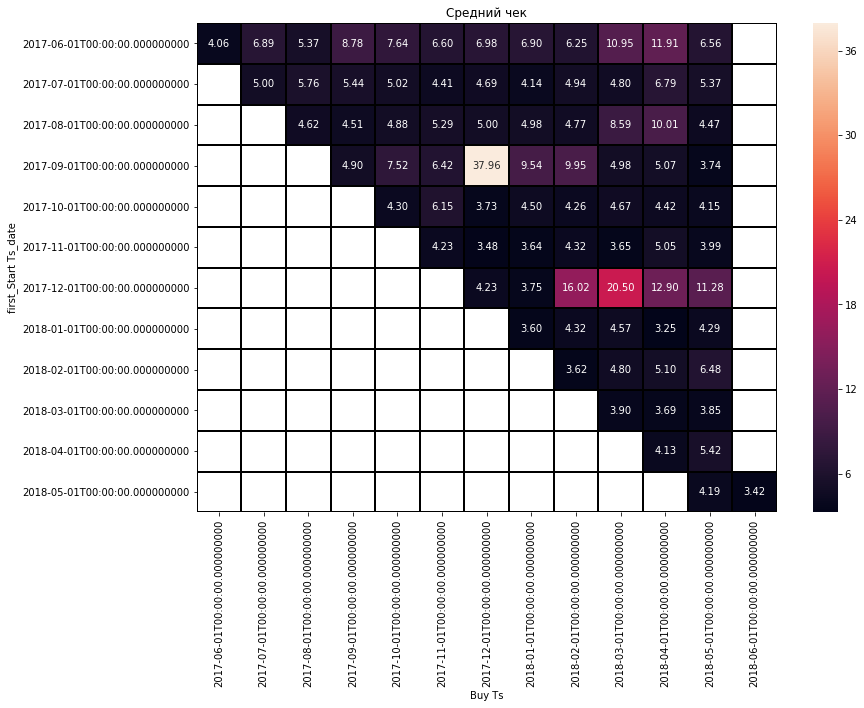

In [91]:
table_mean=orders.groupby(['first_Start Ts_date','Buy Ts']).agg({'Revenue':'sum','Uid':'count'}).reset_index()
table_mean['mean_Revenue']=table_mean['Revenue']/table_mean['Uid']
cogort_table_mean=table_mean.pivot_table(index='first_Start Ts_date',columns='Buy Ts', values='mean_Revenue', aggfunc='sum')
plt.figure(figsize=(13,9))
plt.title('Средний чек')
sns.heatmap(cogort_table_mean, annot= True,fmt='.2f', linewidths=1, linecolor='black')

Когортный анализ показал , что средний чек пользователей держется примерно на одном уровне. Отличилась когорта , которая впервые зашла на сайт  в декабре. После этого с февраля по май делала более высокие средние чеки. Возможно это 1-2 клиента, которые стабильно делают большое количество заказов.
Также был большой всплеск в декабре  пользователей, которые присоединились к яндекс афише в сентябре.

Посмотрим средний чек по периодам:

Text(0.5, 1.0, 'Средний чек в разрезе периодов')

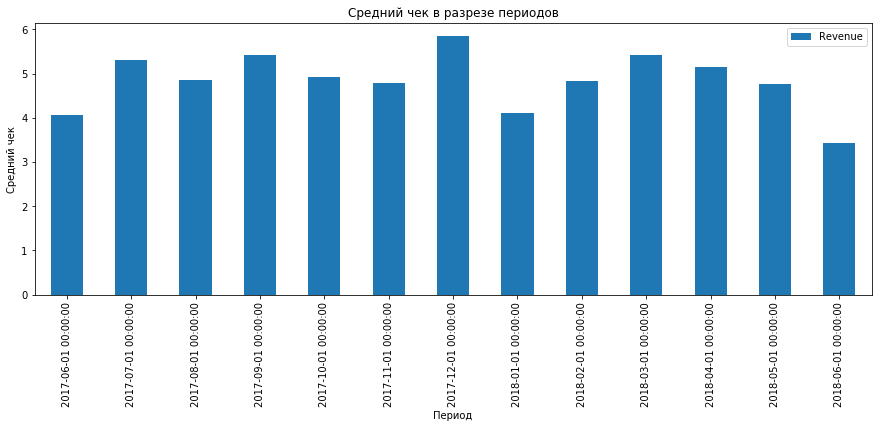

In [92]:
orders.groupby('Buy Ts').agg({'Revenue':'mean'}).reset_index().plot(x='Buy Ts',legend=True,figsize=(15,5), kind='bar')
ax = plt.gca() 
ax.set_xlabel('Период')
ax.set_ylabel('Средний чек')
plt.title('Средний чек в разрезе периодов')

Построили диаграмму по месяцам. Данная диаграмма  также показала самый высокий средний чек в декабре.

Теперь определим сколько в среднем приносит один клиент (LTV) . Для этого придется объединить несколько таблиц. Объединим данные по периоду , источнику и uid пользователя. 

In [93]:
visits=visits.rename(columns={'Source Id':'source_id'})

Сделали переименование для того, чтобы можно было объединять таблицы по столбцу.

In [94]:
visits['datatime']=visits['End Ts'].astype('datetime64[M]')
orders['datatime']=orders['Buy Ts'].astype('datetime64[M]')
costs['datatime']=costs['dt'].astype('datetime64[M]')
display(visits.head(2))
display(orders.head(2))
display(costs.head(2))
display(orders.query('datatime =="2017-06-01"')['Revenue'].sum())

,Device,End Ts,source_id,Start Ts,Uid,Start Ts_year,Start Ts_month,Start Ts_week,Start Ts_date,End Ts_date,sessions,datatime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,2017-12-20,1080,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,2018-02-19,1680,2018-02-01


,Buy Ts,Revenue,Uid,first_Start Ts_date,first_Start_date,Buy_Ts_date,life_time,Start Ts_date,datatime
0,2017-06-01,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01 00:10:00,0,2017-06-01,2017-06-01
1,2017-06-01,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:25:00,0,2017-06-01,2017-06-01


,source_id,dt,costs,datatime
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01


9557.490000000002

Создали период в каждой таблице по которой будет проходить объединение.

Просмотрели, все таблицы готовы к объединению.

Теперь посчитаем средние затраты на одного покупателя и сформируем таблицу

Если смотреть на средние затраты на одного посетителя по месяцам, то можно сделать выводы что они находятся примерно на одном уровне. Думаю, уровень средних затрат в основном зависит из каких источников, какое количество пользователей приходило в том или другом месяце. В июне 2017 года пользователи переходили с более дорогих источников, потом с более дешевых.

In [95]:
visits_01=visits.groupby(['datatime','source_id'])['Uid'].count().reset_index()
costs_01=costs.groupby(['datatime','source_id'])['costs'].sum().reset_index()
costs_02=costs_01.merge(visits_01, on=['datatime','source_id'])
costs_03=costs_02.groupby('datatime').agg({'costs':'sum','Uid':'sum'}).reset_index()
costs_03['costs/Uid']=costs_03['costs']/costs_03['Uid']
display(costs_03)

,datatime,costs,Uid,costs/Uid
0,2017-06-01,18015.00,16499,1.091884
1,2017-07-01,18240.59,17825,1.023315
2,2017-08-01,14790.54,14353,1.030484
3,2017-09-01,24368.91,23896,1.019790
4,2017-10-01,36322.88,37900,0.958387
5,2017-11-01,37907.88,43968,0.862170
6,2017-12-01,38315.35,41980,0.912705
7,2018-01-01,33518.52,36921,0.907844
8,2018-02-01,32723.03,37187,0.879959
9,2018-03-01,30415.27,35682,0.852398


Объединим таблицы с покупками пользователей , чтобы посчитать доходность одного покупателя. 

Мы сформировали таблицу с LTV покупателей. Нет отрицательных значений-это хорошо. Данная таблица схожа с таблицей со средними чеками. Можно выделить когорту с пользователями зашедшими в декабре 2017 года, она делала стабильно большую доходность . Также можно заметить большой всплеск доходности у сентябрьской когорты.

In [96]:
orders['datatime']=orders['datatime'].astype('datetime64[M]')
orders['first_Start_date']=orders['first_Start_date'].astype('datetime64[M]')
orders_ltv_date=orders.groupby('first_Start_date').agg({'Uid':'nunique'}).reset_index()
orders_ltv_date.columns=['first_Start_date','n_buyers']

orders_ltv_date_0=orders.groupby(['first_Start_date','datatime']).agg({'Revenue':'sum'}).reset_index()
orders_ltv_date_1=orders_ltv_date_0.merge(orders_ltv_date, on='first_Start_date')

orders_ltv_date_1['age']=((orders_ltv_date_1['datatime'] - orders_ltv_date_1['first_Start_date']) / np.timedelta64(1, 'M')).round().astype('int')
orders_ltv_date_1['ltv']=orders_ltv_date_1['Revenue']/orders_ltv_date_1['n_buyers']


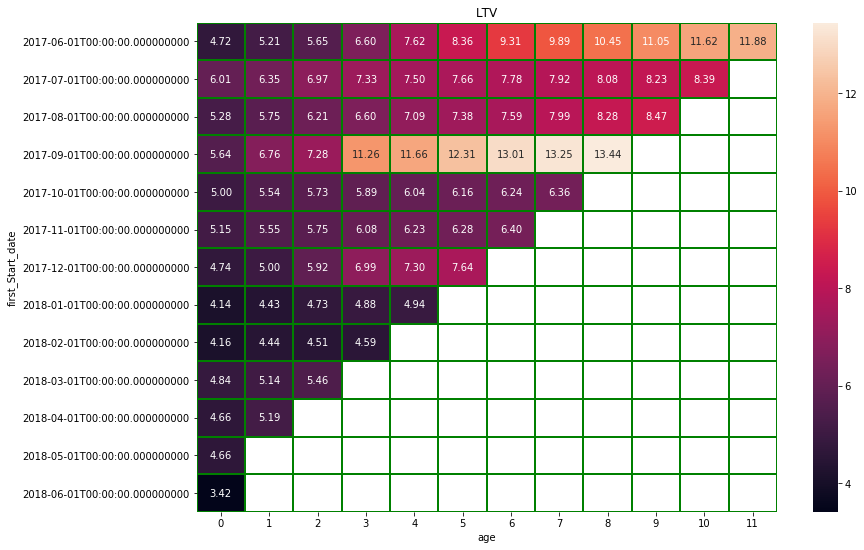

In [97]:
orders_ltv_date_1_table=orders_ltv_date_1.pivot_table(index='first_Start_date', columns='age', values='ltv').cumsum(axis=1).round(2)
plt.figure(figsize=(13,9))
plt.title('LTV')
sns.heatmap(orders_ltv_date_1_table, annot= True, fmt='.2f', linewidths=1, linecolor='green')



Мы сформировали диаграмму с LTV покупателей по когортам, исходя из которой пользователь приносит в первый месяц после своего первого визита на сайт в среднем 5 у.е.
    На последующие месяца после своего первого посещения суммарная средяя прибыль принесенная одним пользователем в когорте почти не менятся, что происходит из-за малого возврата пользователей на Яндекс Афишу. Исключения составили июньская и сентябрьская когорты, чьи пользователи вернулись через несколько месяцев и сделали хорошие покупки, что повысило накопительный  LTV по своей когорте.

In [98]:
min_ltv=visits.groupby('Uid')['Start Ts_date'].min().reset_index()
min_ltv=min_ltv.merge(visits, on='Uid')
min_ltv=min_ltv[min_ltv['Start Ts_date_x']==min_ltv['Start Ts_date_y']][['Uid','source_id']]
min_ltv['Uid'].drop_duplicates(inplace = True)

table_visits_orders=orders.merge(min_ltv, on=['Uid'])

table_visits_orders_costs_source_id=table_visits_orders.groupby(['datatime','source_id']).agg({'Revenue':'sum','Uid':'nunique'}).reset_index()



Подготовили таблицы для объединения. Теперь составим таблицу со средним LTV пользователей в разрезе источников

In [99]:

Orders_total=table_visits_orders.groupby('source_id')['Uid'].nunique()
table_visits_orders_costs_source_id=table_visits_orders_costs_source_id.merge(Orders_total, on='source_id')
display(table_visits_orders_costs_source_id.head())

,datatime,source_id,Revenue,Uid_x,Uid_y
0,2017-06-01,1,418.72,103,2000
1,2017-07-01,1,823.32,109,2000
2,2017-08-01,1,415.89,83,2000
3,2017-09-01,1,655.40,133,2000
4,2017-10-01,1,1241.73,259,2000


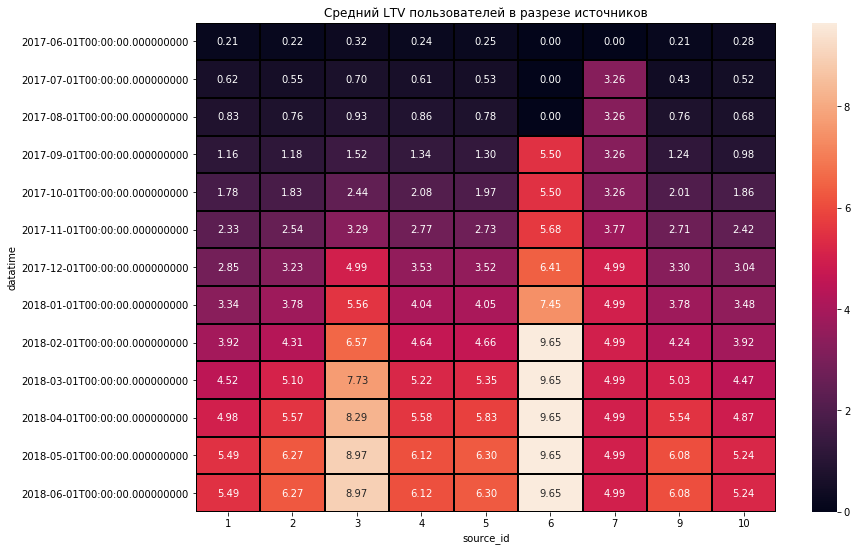

In [100]:
table_visits_orders_costs_source_id['LTV']=table_visits_orders_costs_source_id['Revenue']/table_visits_orders_costs_source_id['Uid_y']

table_visits_orders_costs_source_id_1=table_visits_orders_costs_source_id.pivot_table(index='datatime',columns='source_id',values='LTV',aggfunc='mean')

table_visits_orders_costs_source_id_1=table_visits_orders_costs_source_id_1.fillna(0).cumsum()
plt.figure(figsize=(13,9))
plt.title('Средний LTV пользователей в разрезе источников')

sns.heatmap(table_visits_orders_costs_source_id_1, annot= True,fmt='.2f', linewidths=1, linecolor='black')


Таблица показазала , что пользователи приносят прибыль стабильно примерно на одном уровне, исключения составили пользователи прибывшие изначально из 3 и 6 источника. Их показатели заметно выше остальных .


#### Маркетинг

In [101]:
print(costs['costs'].sum())

329131.62


Всего за период было потрачено 329131.62 у.е. на маркетинг.


Text(0.5, 1.0, 'Затраты на маркетинг за период')

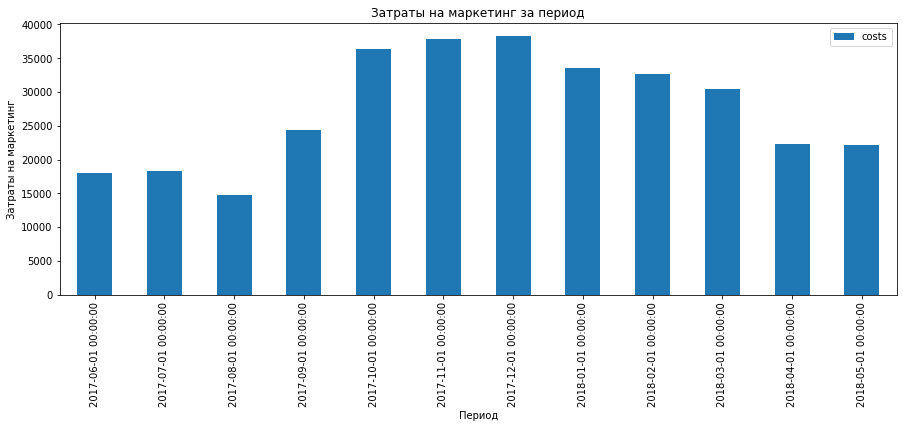

In [102]:
costs_datatime=costs.groupby(['datatime'])['costs'].sum()
costs_datatime.plot(x='datatime',legend=True,figsize=(15,5), kind='bar')
ax = plt.gca() 
ax.set_xlabel('Период')
ax.set_ylabel('Затраты на маркетинг')
plt.title('Затраты на маркетинг за период')

Text(0.5, 1.0, 'Затраты на маркетинг за период')

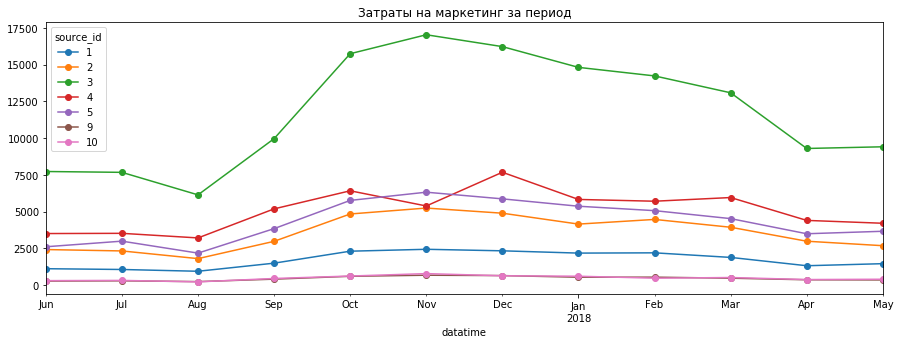

In [103]:
costs.pivot_table(index='datatime', columns='source_id', values='costs', aggfunc='sum').plot(style='-o',figsize=(15,5))
ax.set_xlabel('Период')
ax.set_ylabel('Затраты на маркетинг')
plt.title('Затраты на маркетинг за период')


Самые большые затраты Яндекс афиша тратит на 3 источник (но и пользователи из этого источника приносят больше всео прибыли). 9 и 10 источник наоборот остаются на одинаковом низком уровне.


С ростом продаж , выросли и расходы. С октября виден заметный прирост затрат на привлечение пользователей.

Text(0.5, 1.0, 'Затраты на маркетинг по каналам')

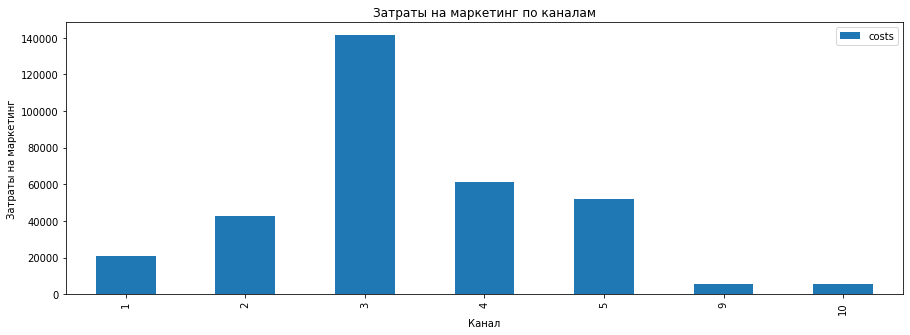

In [104]:
costs_datatime=costs.groupby(['source_id'])['costs'].sum()
costs_datatime.plot(x='source_id',legend=True,figsize=(15,5), kind='bar')
ax = plt.gca() 
ax.set_xlabel('Канал')
ax.set_ylabel('Затраты на маркетинг')
plt.title('Затраты на маркетинг по каналам')

Сформировали диаграмму затрат в разрезе источников . 3 источник является самым дорогостоящим, LSV пользователей пришедших через этот источник по большей части с низкой доходностью или отрицательный

In [105]:
print(orders['Revenue'].sum())
min_ltv=visits.groupby('Uid')['Start Ts_date'].min().reset_index()
min_ltv=min_ltv.merge(visits, on='Uid')
min_ltv=min_ltv[min_ltv['Start Ts_date_x']==min_ltv['Start Ts_date_y']][['Uid','source_id']]

min_ltv['Uid'].drop_duplicates(inplace = True)
orders=orders.merge(min_ltv, on='Uid')
print(orders['Revenue'].sum())
display(orders.head())

252057.2
252057.2


,Buy Ts,Revenue,Uid,first_Start Ts_date,first_Start_date,Buy_Ts_date,life_time,Start Ts_date,datatime,source_id
0,2017-06-01,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01 00:10:00,0,2017-06-01,2017-06-01,2
1,2017-06-01,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01 00:25:00,0,2017-06-01,2017-06-01,4
2,2017-06-01,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01 00:27:00,0,2017-06-01,2017-06-01,4
3,2017-06-01,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01 00:29:00,0,2017-06-01,2017-06-01,5
4,2017-06-01,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01 07:58:00,0,2017-06-01,2017-06-01,4


In [106]:
print(orders.groupby(['source_id']).agg({'Uid':'nunique','Revenue':'sum'}).reset_index())
print(costs.groupby(['source_id']).agg({'costs':'sum'}).reset_index())

   source_id    Uid   Revenue
0          1   2000  10972.57
1          2   2927  18366.39
2          3  10172  91192.15
3          4  11409  69785.43
4          5   7922  49932.58
5          6      1      9.65
6          7      3     14.98
7          9   1003   6097.50
8         10   1086   5685.95
   source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49


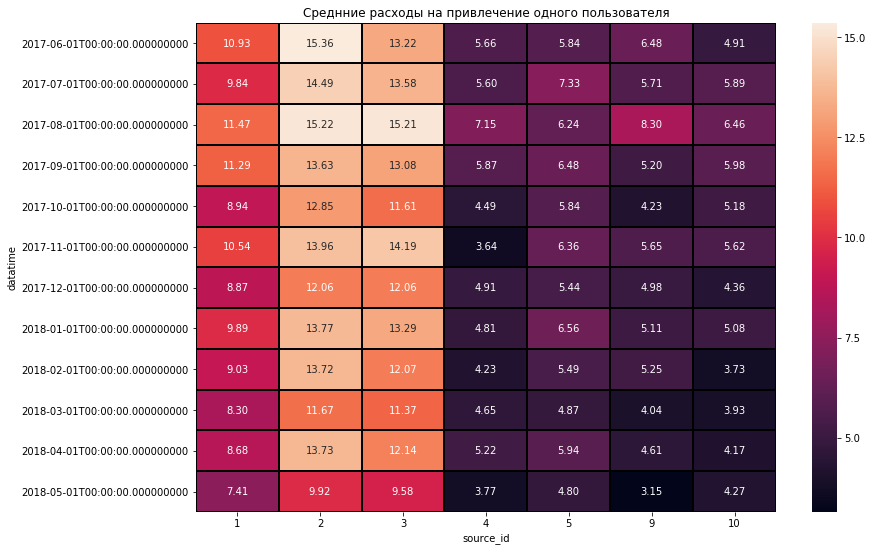

In [107]:
costs_new=costs.groupby(['datatime','source_id']).agg({'costs':'sum'}).reset_index()
visits_new=orders.groupby(['datatime','source_id']).agg({'Uid':'nunique'}).reset_index()

table_visits_costs_new=costs_new.merge(visits_new, on=['datatime','source_id'])
table_visits_costs_new['costs_uid']=table_visits_costs_new['costs']/table_visits_costs_new['Uid']
table_visits_costs_new_1=table_visits_costs_new.pivot_table(index='datatime', columns='source_id', values='costs_uid', aggfunc='sum')
plt.figure(figsize=(13,9))
plt.title('Среднние расходы на привлечение одного пользователя')
sns.heatmap(table_visits_costs_new_1, annot= True,fmt='.2f', linewidths=1, linecolor='black')


Составили таблицу о расходах по каждому источнику в разрезе периодов. Самым дорогостоящим источником по таблице остается источник номер 3. Также довольно высокие затраты на одного пользователя яндекс афиша несет за 2 и 1 источник.

Теперь сформируем Romi и посмотри как быстро окупаются инвестиции.

In [108]:

costs_romi=(costs.groupby('datatime').agg({'costs':'sum'})).reset_index()
costs_romi['first_Start_date']=costs_romi['datatime']
orders_ltv_date_1_costs=costs_romi.merge(orders_ltv_date_1, on='first_Start_date')
orders_ltv_date_1_costs['cac']=orders_ltv_date_1_costs['costs']/orders_ltv_date_1_costs['n_buyers']
orders_ltv_date_1_costs['romi']=orders_ltv_date_1_costs['ltv']/orders_ltv_date_1_costs['cac']
display(orders_ltv_date_1_costs.head())


,datatime_x,costs,first_Start_date,datatime_y,Revenue,n_buyers,age,ltv,cac,romi
0,2017-06-01,18015.0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414,8.905091,0.530530
1,2017-06-01,18015.0,2017-06-01,2017-07-01,981.82,2023,1,0.485329,8.905091,0.054500
2,2017-06-01,18015.0,2017-06-01,2017-08-01,885.34,2023,2,0.437637,8.905091,0.049145
3,2017-06-01,18015.0,2017-06-01,2017-09-01,1931.30,2023,3,0.954671,8.905091,0.107205
4,2017-06-01,18015.0,2017-06-01,2017-10-01,2068.58,2023,4,1.022531,8.905091,0.114825


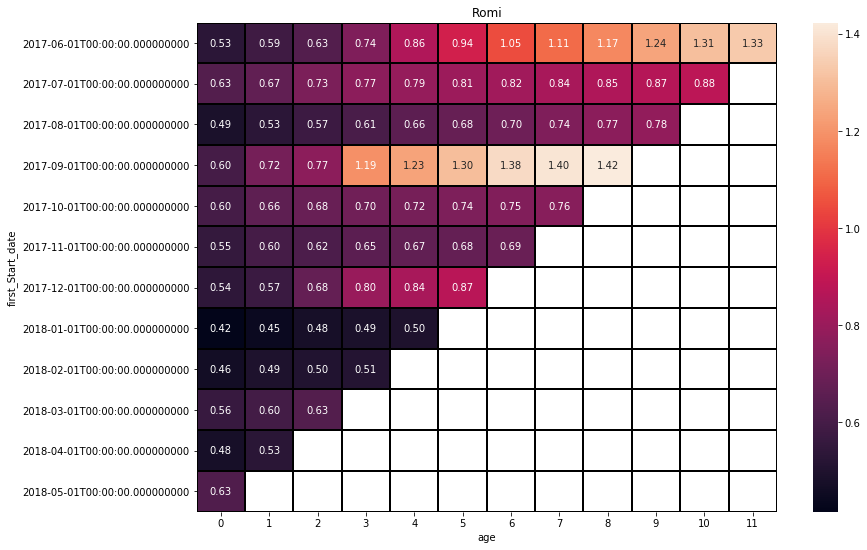

In [109]:
orders_ltv_date_1_costs_table=orders_ltv_date_1_costs.pivot_table(index='first_Start_date', columns='age', values='romi', aggfunc='mean').cumsum(axis=1)
plt.figure(figsize=(13,9))
plt.title('Romi')
sns.heatmap(orders_ltv_date_1_costs_table, annot= True,fmt='.2f', linewidths=1, linecolor='black')


 По данным диаграммы ни одна когорта не окупилась даже после нескольких месяцев. Исключения составили июньская и сентябрьская когорты. Июньская окупилась на 7 месяц, сентябрьская на 4.



,source_id,costs,datatime,Revenue,Uid_x,Uid_y,LTV,CAC,romi
0,1,20833.27,2017-06-01,418.72,103,2000,0.209360,10.416635,0.020099
1,1,20833.27,2017-07-01,823.32,109,2000,0.411660,10.416635,0.039519
2,1,20833.27,2017-08-01,415.89,83,2000,0.207945,10.416635,0.019963
3,1,20833.27,2017-09-01,655.40,133,2000,0.327700,10.416635,0.031459
4,1,20833.27,2017-10-01,1241.73,259,2000,0.620865,10.416635,0.059603


Text(0.5, 1, 'ROMI по источникам')

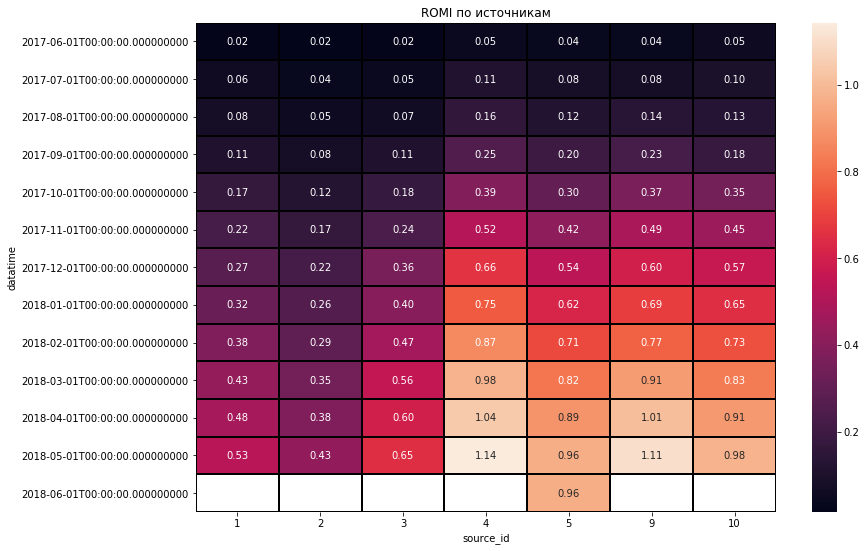

In [110]:

costs_source_id_romi=costs.groupby(['source_id'])['costs'].sum()
costs_source_id_romi=costs_source_id_romi.reset_index()
costs_source_id_romi=costs_source_id_romi.merge(table_visits_orders_costs_source_id, on=['source_id'])
costs_source_id_romi['LTV']=costs_source_id_romi['Revenue']/costs_source_id_romi['Uid_y']
costs_source_id_romi['CAC']=costs_source_id_romi['costs']/costs_source_id_romi['Uid_y']
costs_source_id_romi['romi']=costs_source_id_romi['LTV']/costs_source_id_romi['CAC']
display(costs_source_id_romi.head())
costs_source_id_romi_table=costs_source_id_romi.pivot_table(index='datatime', columns='source_id', values='romi', aggfunc='sum').cumsum()
plt.figure(figsize=(13,9))
sns.heatmap(costs_source_id_romi_table, annot= True,fmt='.2f', linewidths=1, linecolor='black')    

plt.title('ROMI по источникам')



    По сделанной диаграмме можно сказать, что 1 и 2 источник находятся примерно на одном уровне, 2 источник имеет более высокий накопленный LTV, но и расходов по этому источнику намного больше, поэтому 1 источник окупается немного быстрее. 
    3 источник на 12 месяце жизни дает 0,65 ROMI ( затраты окупились на 65%). Более удачная комбинация расходов по 4,5,9 и 10 источникам ( имеют более высокий LTV по сравнению с CAC ), поэтому затраты на привлечения пользователей окупаются у всех на 2 месяц работы источников, а окупаемость затрат на 12 месяц превышает 96%.
    Данных по ROMI по 6 и 7 источнику нет, так как и не было затрат.

Теперь посмотрим те же метрики по каждому дивайсу отдельно.

In [111]:
display(orders.tail())

,Buy Ts,Revenue,Uid,first_Start Ts_date,first_Start_date,Buy_Ts_date,life_time,Start Ts_date,datatime,source_id
50410,2018-05-01,4.64,12296626599487328624,2018-05-01,2018-05-01,2018-05-31 23:50:00,0,2018-05-31,2018-05-01,3
50411,2018-05-01,5.80,11369640365507475976,2018-05-01,2018-05-01,2018-05-31 23:50:00,0,2018-05-31,2018-05-01,5
50412,2018-05-01,0.30,1786462140797698849,2018-05-01,2018-05-01,2018-05-31 23:54:00,0,2018-05-31,2018-05-01,5
50413,2018-05-01,3.67,3993697860786194247,2017-10-01,2018-05-01,2018-05-31 23:56:00,7,2017-10-23,2018-05-01,4
50414,2018-06-01,3.42,83872787173869366,2018-05-01,2018-06-01,2018-06-01 00:02:00,1,2018-05-31,2018-06-01,5


In [112]:
visit_device=visits[['Device','Uid']]
orders_device=orders.merge(visit_device, on='Uid')
costs_02['costs/Uid']=costs_02['costs']/costs_02['Uid']
display(costs_02.head(2))
display(orders_device.head(2))
orders_device=orders_device.merge(costs_02, on=['source_id','datatime'])
orders_device['LTV']=orders_device['Revenue']-orders_device['costs/Uid']
orders_device['ROI']=(orders_device['LTV']-orders_device['costs/Uid'])/orders_device['costs/Uid']
display(orders_device.head(2))

,datatime,source_id,costs,Uid,costs/Uid
0,2017-06-01,1,1125.61,1544,0.729022
1,2017-06-01,2,2427.38,2191,1.107887


,Buy Ts,Revenue,Uid,first_Start Ts_date,first_Start_date,Buy_Ts_date,life_time,Start Ts_date,datatime,source_id,Device
0,2017-06-01,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01 00:10:00,0,2017-06-01,2017-06-01,2,desktop
1,2017-06-01,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01 00:25:00,0,2017-06-01,2017-06-01,4,desktop


,Buy Ts,Revenue,Uid_x,first_Start Ts_date,first_Start_date,Buy_Ts_date,life_time,Start Ts_date,datatime,source_id,Device,costs,Uid_y,costs/Uid,LTV,ROI
0,2017-06-01,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01 00:10:00,0,2017-06-01,2017-06-01,2,desktop,2427.38,2191,1.107887,15.892113,13.344528
1,2017-06-01,1.47,4899721912549460321,2017-06-01,2017-06-01,2017-06-01 14:20:00,0,2017-06-01,2017-06-01,2,desktop,2427.38,2191,1.107887,0.362113,-0.673150


Подготовили таблицы для последующего объединения и создания таблиц и графиков.

In [113]:
print(visit_device['Device'].unique())

['touch' 'desktop']


Посмотрели, всего зафиксировано 2 дивайса.

In [114]:

Visits_Device=visits[['Uid','Device']]
Visits_Device['Uid'].drop_duplicates(inplace = True)
orders=orders.merge(Visits_Device, on='Uid')

orders_LTV=orders.groupby(['first_Start Ts_date','Device']).agg({'Uid':'nunique'}).reset_index()
orders_LTV.columns=['first_Start Ts_date','Device','n_byes']
Visits_Device_0=orders.merge(orders_LTV, on=['first_Start Ts_date','Device'])

print(orders_LTV.head())

  first_Start Ts_date   Device  n_byes
0          2017-06-01  desktop    2131
1          2017-06-01    touch     792
2          2017-07-01  desktop    1787
3          2017-07-01    touch     671
4          2017-08-01  desktop    1281


/opt/conda/lib/python3.7/site-packages/pandas/core/base.py:1629: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


252057.19999999984


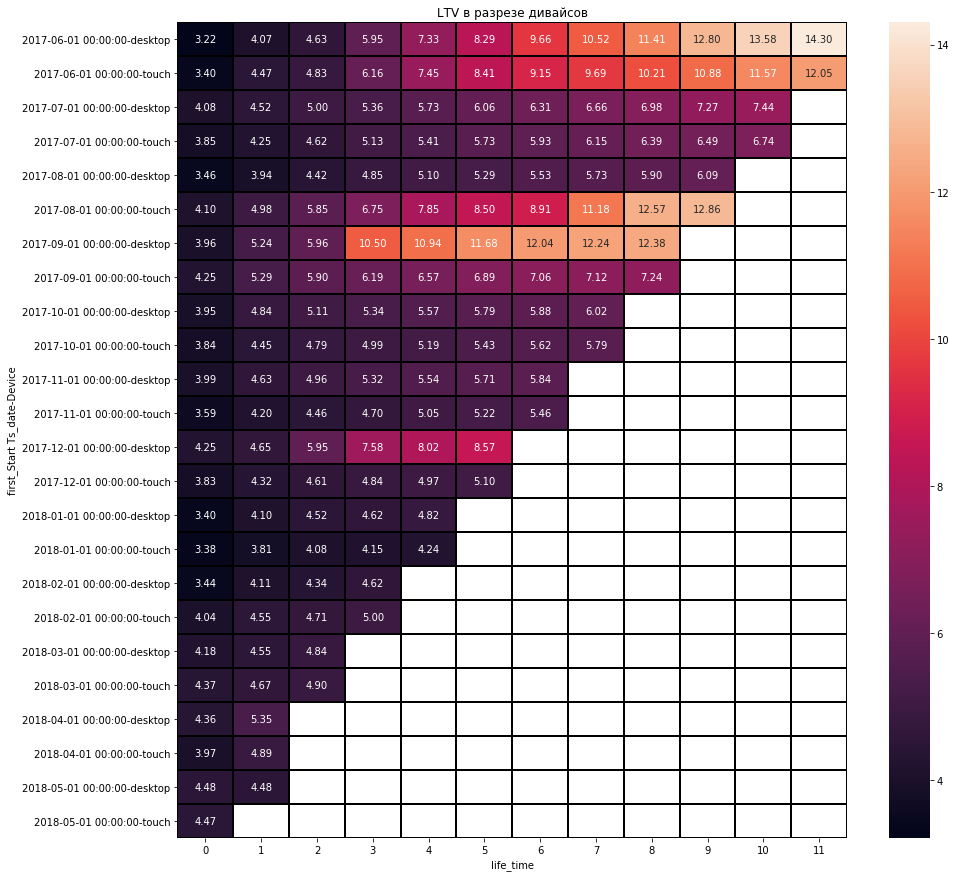

In [115]:
Visits_Device_0_table=orders.groupby(['first_Start Ts_date','life_time','Device']).agg({'Revenue':'sum'}).reset_index()
Visits_Device_0_table=Visits_Device_0_table.merge(orders_LTV, on=['first_Start Ts_date','Device'])
print(Visits_Device_0_table['Revenue'].sum())
Visits_Device_0_table['LTV']=Visits_Device_0_table['Revenue']/Visits_Device_0_table['n_byes']
Visits_Device_0_table_1=Visits_Device_0_table.pivot_table(index=['first_Start Ts_date','Device'], columns='life_time', values='LTV').cumsum(axis=1)
plt.figure(figsize=(15,15))
plt.title('LTV в разрезе дивайсов')
sns.heatmap(Visits_Device_0_table_1, annot= True,fmt='.2f', linewidths=1, linecolor='black')

Есть небольшые различия в накопительном LTV  по разным дивайсам. В августовской когорте по дивайсу touch заметен более высокий LTV, по сентябрьской когорте наоборот,  у desktop более высокий показатель.
В целом при делении на начисления когорт по дивайсам показатели остаются на одном уровне. Думаю дивайсы ни  на что не влияют.

In [116]:
Visits_Device_0=Visits_Device_0.merge(min_ltv, on='Uid')

Text(0.5, 1, 'LTV по источникам и дивайсам')

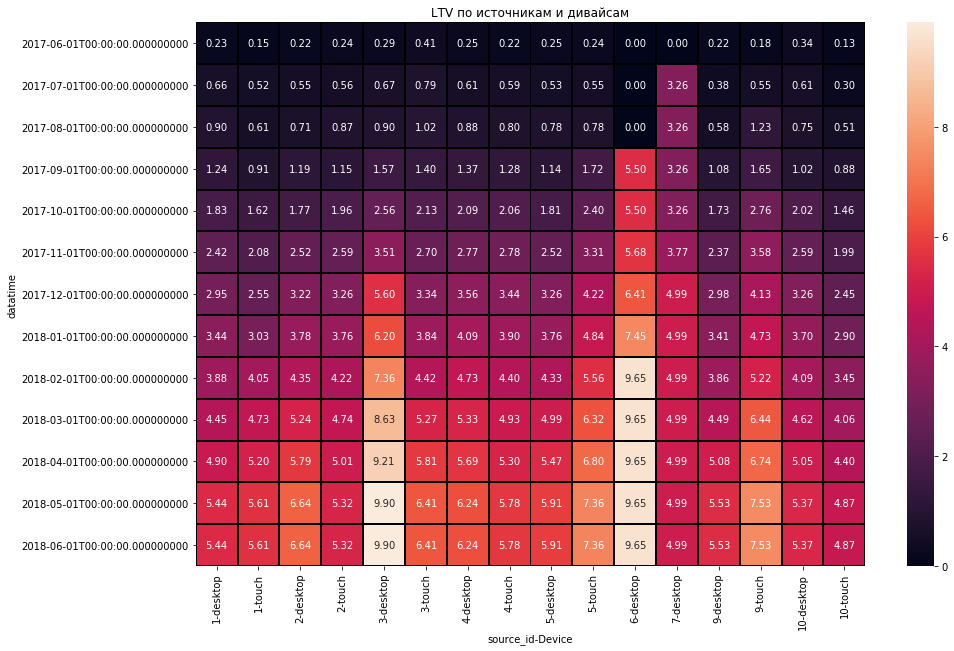

In [117]:


orders_totaluid=orders.groupby(['source_id','Device'])['Uid'].nunique().reset_index()

orders_totaluid.columns=['source_id','Device','n_buyers']

orders_LTV=orders.groupby(['source_id','Device','datatime']).agg({'Revenue':'sum'}).reset_index()
orders_LTV=orders_LTV.merge(orders_totaluid, on=['source_id','Device'])
orders_LTV['LTV']=orders_LTV['Revenue']/orders_LTV['n_buyers']
orders_LTV_table11=orders_LTV.pivot_table(index='datatime', columns=['source_id','Device'], values='LTV', aggfunc='sum')
orders_LTV_table11=orders_LTV_table11.fillna(0).cumsum()
plt.figure(figsize=(15,10))
sns.heatmap(orders_LTV_table11, annot= True,fmt='.2f', linewidths=1, linecolor='black')    

plt.title('LTV по источникам и дивайсам')

Тут также показатели остаются примерно на одном уровне. Выделяются 3 и 6 источник с дивайсом desktop у которых заметен более высокий какопленный LTV.

#### Общий вывод  <a class="anchor" id="5-bullet"></a>

   В данной работе мы просмотрели данные, изменили тип даты в каждой таблице. Поскольку при анализе данных было обнаружено много выбросов в длительности сессий (было много нулевых  и неадекватно больших значений), мы посчитали медианное значение длительности сессии, которое составило 5 минут.
   Также был проведен анализ посещения и покупок пользователей. Обычно пользователи начинают покупать в первый день посещения Яндекс афиши и чаще всего больше ее не посещают. В данном случае моей рекомендацией будет  проведения акций и  мероприятий по развитию продаж для мотивации пользователей вернуться за повторными покупками. 
    При анализе мы обнаружили  рост продаж с сентября 2017 года. Выросла как выручка, так и количество заказов.
Также был проведен когортный анализ посетителей сайта . Когорты мы образовывали по месяцу первого посещения Яндекс афиши.
Анализ показал , что средний чек пользователей держется примерно на одном уровне. Отличилась когорта , которая впервые зашла на сайт  в декабре, после этого с февраля по май делала более высокие средние чеки. 
Еще можно заметить, что был большой всплеск в декабре  пользователей, которые присоединились к яндекс афише в сентябре.
    Также мы сформировали таблицу с LTV покупателей по кагортам, исходя из которой пользователь приносит в первый месяц после своего первого визита на сайт в среднем 4 у.е.На последующие месяца после своего первого посещения суммарная средяя прибыль принесенная одним пользователем в когорте почти не менятся, что происходит из-за малого возврата пользователей на Яндекс Афишу. Исключения составили июньская и сентябрьская когорты, чьи пользователи вернулись через несколько месяцев и сделали хорошие покупки, что повысило накопительный  LTV по своей когорте.
    Таблица LTV в разрезе источников показазала , что пользователи приносят прибыль стабильно примерно на одном уровне, исключения составили пользователи прибывшие изначально из 3 и 6 источника. Их показатели заметно выше остальных .
 
 Взглянув на затраты на эти источники можно сказать , что  на 3 источник расходуется большое количество средств и эти расходы довольно слабо окупаются.  Можно сказать, что 1 и 2 источник находятся примерно на одном уровне, 2 источник имеет более высокий накопленный LTV, но и расходов по этому источнику намного больше, поэтому 1 источник окупается немного быстрее. 
    3 источник на 12 месяце жизни дает 0,65 ROMI ( затраты окупились на 65%). Более удачная комбинация расходов по 4,5,9 и 10 источникам ( имеют более высокий LTV по сравнению с CAC ), поэтому затраты на привлечения пользователей окупаются у всех на 2 месяц работы источников, а окупаемость затрат на 12 месяц превышает 96%.
    Данных по ROMI по 6 и 7 источнику нет, так как и не было затрат.
    В данном случае моей рекомендацией будет развивать 4,5,6,7,9 и 10 источники, так как затраты ( если они есть) на эти источники быстрее окупаются и в последствии быстрее приносят прибыль.
